In [85]:
from typing import List
import pandas as pd
import copy
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import numpy as np


In [86]:
data_poems = pd.read_csv(r'./data/poems.csv')

print(f'Всего стихов в датасете: {len(data_poems)}',
      f' - Бродского: {sum(map(lambda x : x == "Brodsky" , data_poems["Author"]))} ({sum(map(lambda x : x == "Brodsky" , data_poems["Author"])) * 100 // len(data_poems)}%)',
      f' - Шекспира: {sum(map(lambda x : x == "Shakespeare" , data_poems["Author"]))} ({sum(map(lambda x : x == "Shakespeare" , data_poems["Author"])) * 100 // len(data_poems)}%)',
      sep='\n')
data_poems.head(2)

data_poems = shuffle(data_poems).reset_index(drop=True)

data_poems.head(2)

Всего стихов в датасете: 997
 - Бродского: 597 (59%)
 - Шекспира: 400 (40%)


,Poem,Author
0,['\r\n Tired with ...,Shakespeare
1,['\r\n Being your ...,Shakespeare


In [87]:
# Отделим данные от того, что нам нужно предсказать
X = data_poems.drop('Author', axis=1)
y = data_poems['Author']

# Для удобства введем сокращения
AS = 'Amount of sentences'
LS = 'Average length of sentence'
WL = 'Average word length in sentences'

# Добавим эти характеристики к датасету
amount_of_sentences = []
len_of_sentences = []
words_average_len_in_sentences = []

for poem in X['Poem']:
    sentences = nltk.sent_tokenize(poem)
    amount_of_sentences.append(len(sentences))
    sum_of_words = 0
    sum_of_letters = 0
    for sentence in sentences:
        sentence = nltk.word_tokenize(sentence)
        sum_of_words += len(sentence)
        for word in sentence:
            sum_of_letters += len(word)
    len_of_sentences.append(sum_of_words/len(sentences))
    words_average_len_in_sentences.append(sum_of_letters/sum_of_words)

X[AS] = amount_of_sentences # amount of sentences in poem
X[LS] = len_of_sentences # average amount of words in sentence
X[WL] = words_average_len_in_sentences  # words length

Взглянем на данные

In [88]:
print('Author:')
print(y[:2], end='\n\n')
X.head(2)



Author:
0    Shakespeare
1    Shakespeare
Name: Author, dtype: object



,Poem,Amount of sentences,Average length of sentence,Average word length in sentences
0,['\r\n Tired with ...,2,78.5,3.439490
1,['\r\n Being your ...,4,45.5,2.994505


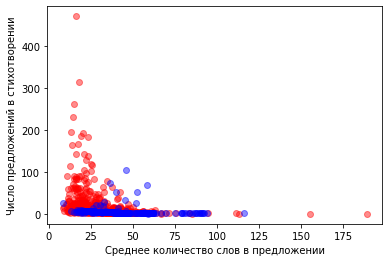

In [93]:
def show_poems_graph(poems, authors, comment_x, x, comment_y, y, alpha=0.45, name1='Brodsky', name2='Shakespeare',
                     line_point_1=None, line_point_2=None):
    """
    Выводит скаттерплот по данным характеристикам, где красные точки - И. Бродский,
    синие - У. Шекспир
    """

    name1_indexes = authors[authors == name1].index
    name2_indexes = authors[authors == name2].index
    if len(name1_indexes) < len(name2_indexes):
        name1_indexes, name2_indexes = name2_indexes, name1_indexes

    plt.scatter(x = x,y = y,
                data = poems[poems.index.isin(name1_indexes)],
                color='red',
                alpha=alpha)

    plt.scatter(x = x,y = y,
                data = poems[poems.index.isin(name2_indexes)],
                color='blue',
                alpha=alpha)

    #ax.set_facecolor('white')
    plt.xlabel(comment_x, color='black')
    plt.ylabel(comment_y, color='black')
    if line_point_1 is not None and line_point_2 is not None:
        plt.plot(line_point_1, line_point_2, 'k-', lw=2)
    plt.show()

show_poems_graph(X, y, 'Среднее количество слов в предложении', LS,
                  'Число предложений в стихотворении', AS)

Заметим, закономерность: у Бродского чаще больше предложений в стихотворении, а у Шекспира - слов в 1 предложении.

Отложим экстремальные значения, чтобы лучше рассмотреть сгусток точек.

Число стихов после в малом датасете: 997-96=901 (90%)
 - Бродского: 526 (58%)
 - Шекспира: 375 (41%)


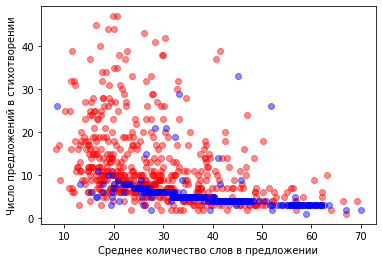

In [40]:
extreme_indexes = X[(X[LS] > 70) | (X[AS] > 47)].index
X_small = X.drop(index=extreme_indexes)
y_small = y.drop(index=extreme_indexes)

print(f'Число стихов после в малом датасете: {len(X)}-{len(X)-len(X_small)}={len(X_small)} ({len(X_small) * 100 // len(X)}%)',
    f' - Бродского: {sum(map(lambda x : x == "Brodsky" , y_small))} ({sum(map(lambda x : x == "Brodsky" , y_small)) * 100 // len(y_small)}%)',
    f' - Шекспира: {sum(map(lambda x : x == "Shakespeare" , y_small))} ({sum(map(lambda x : x == "Shakespeare" , y_small)) * 100 // len(y_small)}%)',
    sep='\n')

show_poems_graph(X_small, y_small, 'Среднее количество слов в предложении', LS,
                  'Число предложений в стихотворении', AS)

Будем обучать модель именно на малом датасете, для того чтобы избавиться от выбросов

Для задачи линейной классификации будем использовать перцептрон, на который потом добавим метод вспомогательных векторов.


In [41]:
X_small = X_small.drop('Poem', axis=1).drop(WL, axis=1)

In [42]:
# Заменим Бродского на 1, Шекспира на 0
y_small = [int(author == 'Brodsky') for author in y_small]

X_train, X_valid, y_train, y_valid = train_test_split(X_small, y_small,
                                                      test_size=0.3, random_state=42)

In [176]:
fails = 0

class Perceptron(object):

    def __init__(self, no_of_inputs, threshold=1000, learning_rate=0.01):
        self.threshold = threshold
        self.learning_rate = learning_rate
        # self.weights = [np.random.random(2)-1 for i in range(no_of_inputs)]
        self.weights = np.random.random(no_of_inputs + 1) - [0.5] * 3
        print(self.weights)

    def train(self, training_inputs, labels):
        for _ in range(self.threshold):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.predict(inputs)
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs
                self.weights[0] += self.learning_rate * (label - prediction)

    # def predict(self, inputs) -> int:
    #     summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
    #     if not isinstance(summation, float):
    #         global fails
    #         fails += 1
    #         return 1
    #     if summation > 0:
    #         activation = 1
    #     else:
    #         activation = 0
    #     return activation

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict(self, inputs) -> int:
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        sig = self.sigmoid(summation)
        return sig
        # if not isinstance(summation, float):
        #     global fails
        #     fails += 1
        #     return 1
        # if summation > 0:
        #     activation = 1
        # else:
        #     activation = 0
        # return activation



In [181]:
def df_predict(df, predict) -> List:
    predictions = list()
    for line in df:
        predictions.append(predict(line))
    return predictions

def accuracy(answers, right_answers):
    if len(answers) != len(right_answers):
        print("Warning (accuracy): len(answers) != len(right_answers)")
    return sum([(answers[i] - 0.5) * (right_answers[i] - 0.5) > 0 for i in range(len(answers))]) / len(answers)

In [182]:
perceptron = Perceptron(no_of_inputs=2)
perceptron.train(X_train.to_numpy(), y_train)

print(accuracy(df_predict(X_train.to_numpy(), perceptron.predict), y_train))
print(accuracy(df_predict(X_valid.to_numpy(), perceptron.predict), y_valid))

[0.41257602 0.30088813 0.46481924]
0.6365079365079365
0.6531365313653137


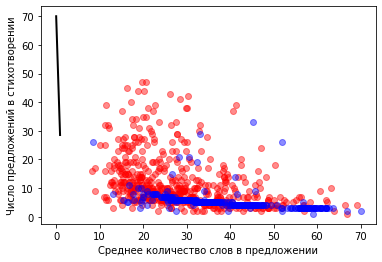

In [175]:
extreme_indexes = X[(X[LS] > 70) | (X[AS] > 47)].index
X_small = X.drop(index=extreme_indexes)
y_small = y.drop(index=extreme_indexes)

sqrt = (perceptron.weights[0]**2 + perceptron.weights[1]**2 + perceptron.weights[2]**2)**(1/2)
a = perceptron.weights[1] / sqrt
b = perceptron.weights[2] / sqrt
c = perceptron.weights[0] / sqrt
def get_y(x) -> float:
    global a, b, c
    return (c - a * x) / b

show_poems_graph(X_small, y_small,
                'Среднее количество слов в предложении', LS,
                'Число предложений в стихотворении', AS,
                 line_point_1=[0, -perceptron.weights[0]/perceptron.weights[1]],
                 line_point_2=[70, (-70*perceptron.weights[2] - perceptron.weights[0])/perceptron.weights[1]])

In [112]:
y_small = y.drop(index=extreme_indexes)
y_small = [int(author == 'Brodsky') for author in y_small]
print(sum(y_small)/len(y_small))

0.5837957824639289


In [183]:
print(perceptron.weights)

[-1.28157327  0.84286719 -0.33241229]
